In [3]:
%matplotlib widget

# The potential of the electromagnetic induction method to monitor temperature changes in the near-surface

## Maria Carrizo, Dieter Werthmüller, and Evert Slob
Delft University of Technology, Faculty of Civil Engineering and Geosciences , Department of Applied Geophysics and Petrophysics, Delft, Netherlands (m.e.carrizomascarell@tudelft.nl)

### Feasibility analysis based in experimental case with synthetic measurements

With the cases simulated for increasing temperature time steps, we assume knowing the electrical conductivity of the unsaturated fine sands and the sandy clay layer. Three unknowns remain, the conductivity of the saturated fine sand and the thicknesses of the unsaturated and saturated fine sands ($\mathbf{m} = [\sigma_2, h_1, h_2]$). Using the gradient descent method we estimated these models with acceptable results.

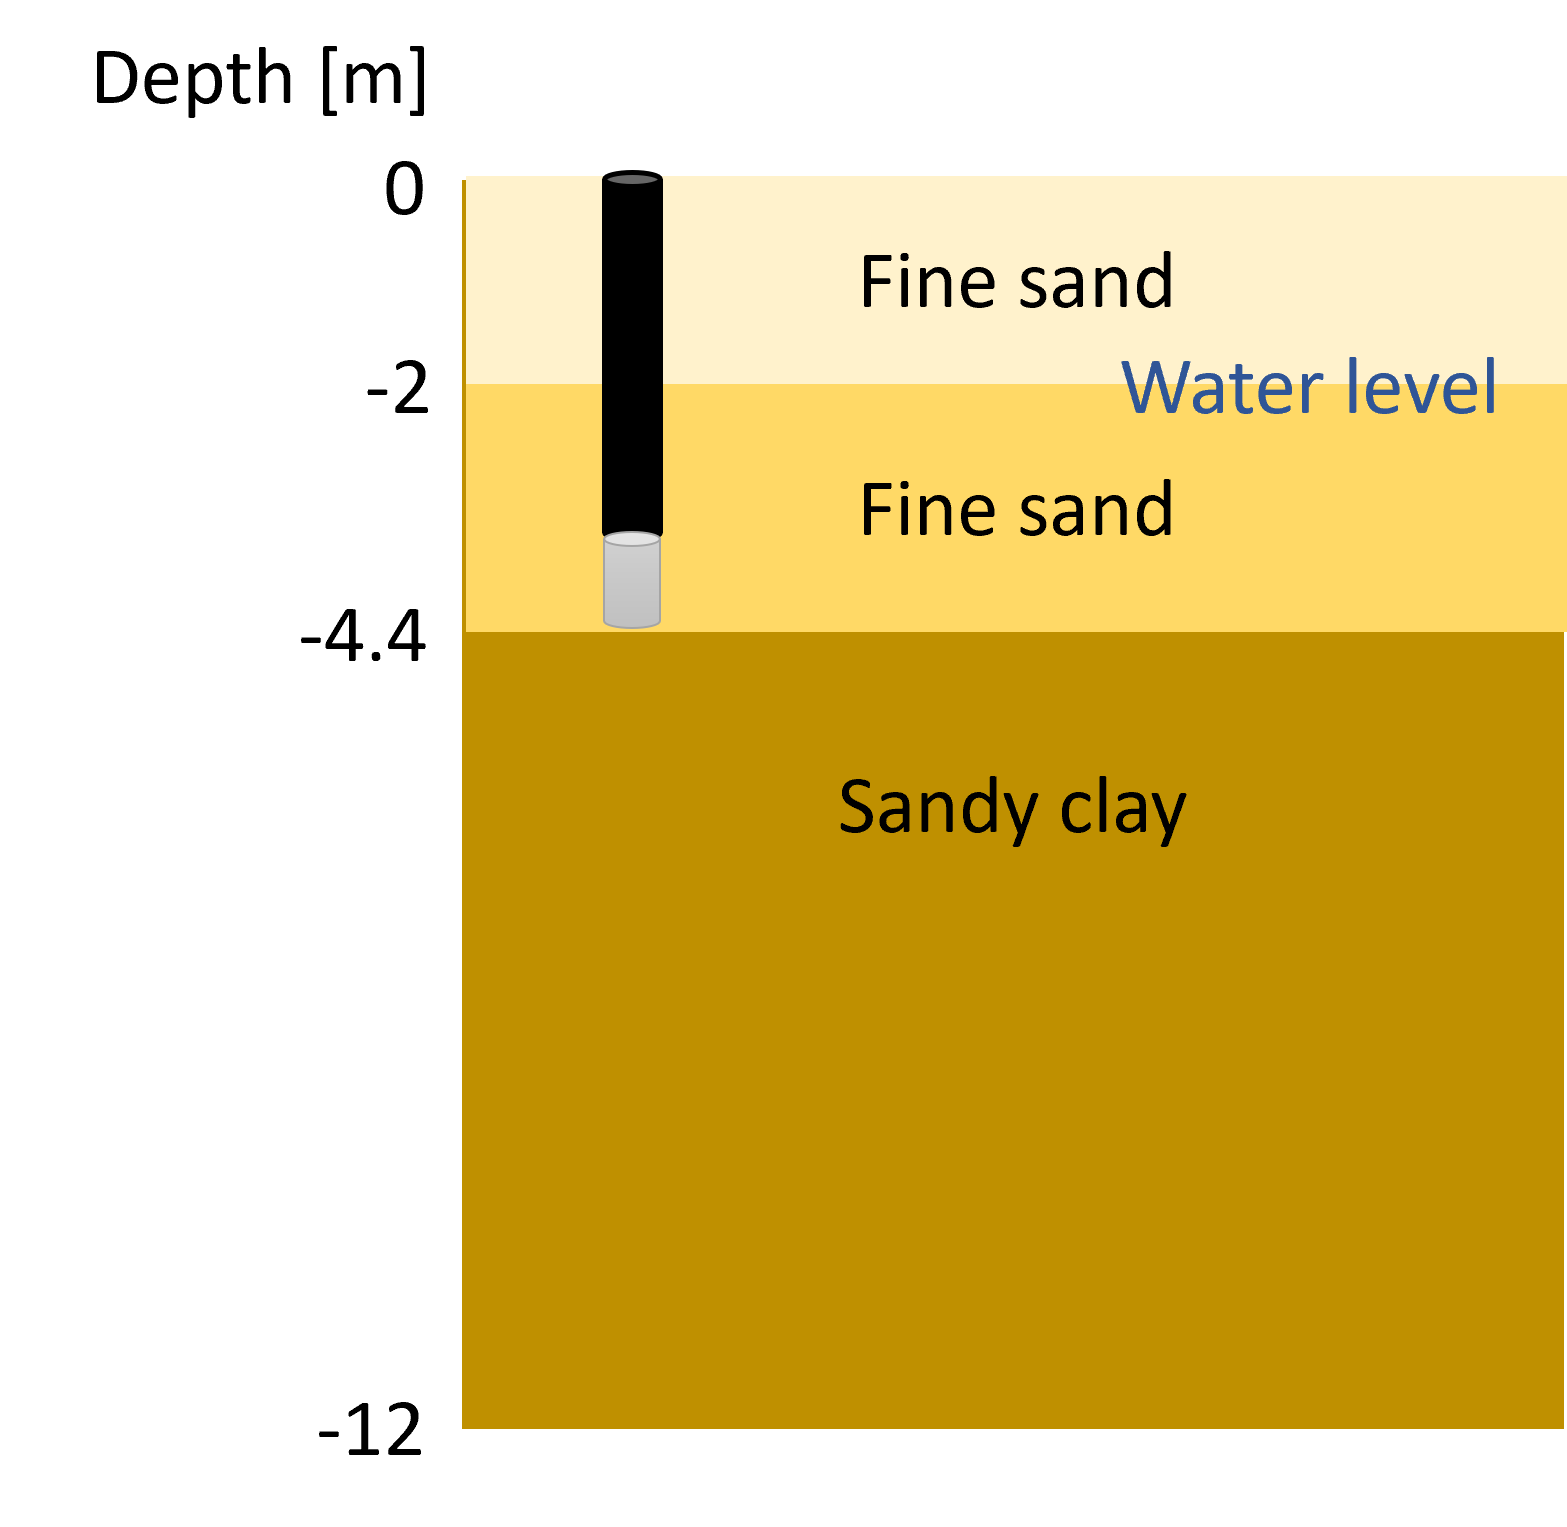

In [4]:
from IPython.display import Image
Image(filename = "Lithology.png", width=300, height=300)

In [6]:
# Import Libraries

import numpy as np
import matplotlib.pyplot as plt
from empymod import filters
import pygimli as pg
import sys
sys.path.insert(1, 'src')

# Load function that performs global search in lookup table
from EM1D import EMf_3Lay_HVP, EMf_3Lay_Opt_HVP_cons
from utils import rmse

In [7]:
# Settings for measurements simulations

# Define hankel filter
filt = filters.key_201_2012() 

# Define EMI instrument geometry
offsets = np.array([2, 4, 8]) # in meters
height = 0.10 # meters height from ground surface to center of coils
freq = 9000 # Frequency in Hz
# Lambda numbers
lambd = filt.base/offsets[:,np.newaxis] 

### Defining initial parameters of the experiment

In [8]:
ini_temp = 10
end_temp = 51

T = np.linspace(ini_temp, end_temp, 41, endpoint=False)
sigma_25 = 43
m = 0.020

sigma_bulk = (m * (T - 25) + 1) * sigma_25

For a range of time steps we simulate synthetic data and analyse the data difference  

- Time Step 1: $T = 10 °C$ (Baseline)
- Time Step 2: $T = 20 °C$
- Time Step 3: $T = 30 °C$
- Time Step 4: $T = 40 °C$
- Time Step 5: $T = 50 °C$

### Define the synthetic EC model for each time step

In [9]:
# Experiment parameters:
sigma_fs1 = 10 # mS/m sigma fine sand unsaturated
sigma_sc  = 350 # mS/m sigma of sandy clay
h1 = 2 # Thickness of first layer
h2 = 2.4 # Thickness of second layer
depth2 = h1 + h2
dmax = 12

# Temperature at each Time step
T_TS1 = 10
T_TS2 = 20
T_TS3 = 30
T_TS4 = 40
T_TS5 = 50

# Defining sigma_fs2 for each time step
sigma_fs2_TS1 = sigma_bulk[np.argwhere(T == T_TS1)[0][0]]
sigma_fs2_TS2 = sigma_bulk[np.argwhere(T == T_TS2)[0][0]]
sigma_fs2_TS3 = sigma_bulk[np.argwhere(T == T_TS3)[0][0]]
sigma_fs2_TS4 = sigma_bulk[np.argwhere(T == T_TS4)[0][0]]
sigma_fs2_TS5 = sigma_bulk[np.argwhere(T == T_TS5)[0][0]]

# Define EC models
model_TS1 = np.array([sigma_fs1, sigma_fs2_TS1, sigma_sc, sigma_sc])
model_TS2 = np.array([sigma_fs1, sigma_fs2_TS2, sigma_sc, sigma_sc])
model_TS3 = np.array([sigma_fs1, sigma_fs2_TS3, sigma_sc, sigma_sc]) 
model_TS4 = np.array([sigma_fs1, sigma_fs2_TS4, sigma_sc, sigma_sc]) 
model_TS5 = np.array([sigma_fs1, sigma_fs2_TS5, sigma_sc, sigma_sc]) 

depths = np.array([0, -h1, -h1 - h2, -dmax])

### Simulate measurements

In [10]:
# Simulate measurements
# Note: Sigmas in unit of S/m

data_TS1 = EMf_3Lay_HVP(lambd = lambd, sigma1 = sigma_fs1/1000, sigma2 = sigma_fs2_TS1/1000, 
                        sigma3 = sigma_sc/1000, h1 = h1, h2 = h2, height = height, offsets = offsets,
                         freq = freq, filt = filt)

data_TS2 = EMf_3Lay_HVP(lambd = lambd, sigma1 = sigma_fs1/1000, sigma2 = sigma_fs2_TS2/1000, 
                        sigma3 = sigma_sc/1000, h1 = h1, h2 = h2, height = height, offsets = offsets,
                         freq = freq, filt = filt)

data_TS3 = EMf_3Lay_HVP(lambd = lambd, sigma1 = sigma_fs1/1000, sigma2 = sigma_fs2_TS3/1000, 
                        sigma3 = sigma_sc/1000, h1 = h1, h2 = h2, height = height, offsets = offsets,
                         freq = freq, filt = filt)

data_TS4 = EMf_3Lay_HVP(lambd = lambd, sigma1 = sigma_fs1/1000, sigma2 = sigma_fs2_TS4/1000, 
                        sigma3 = sigma_sc/1000, h1 = h1, h2 = h2, height = height, offsets = offsets,
                         freq = freq, filt = filt)

data_TS5 = EMf_3Lay_HVP(lambd = lambd, sigma1 = sigma_fs1/1000, sigma2 = sigma_fs2_TS5/1000, 
                        sigma3 = sigma_sc/1000, h1 = h1, h2 = h2, height = height, offsets = offsets,
                         freq = freq, filt = filt)

### Estimate EC model for Time step TS1

In [ ]:
# Initialize the forward modelling class 
EMf = EMf_3Lay_Opt_HVP_cons(lambd, height, offsets, freq, filt, sigma1 = sigma_fs1/1000, sigma3 = sigma_sc/1000)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

transModel = pg.trans.TransLogLU(0.01,3) 
invEM.modelTrans = transModel

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_TS1) * error

# Start inversion
model_3Lay_est_TS1 = invEM.run(data_TS1, relativeError, verbose=False)

# Data from estimated model
data_3Lay_est_TS1 = EMf_3Lay_HVP(lambd, 
                             sigma1 = sigma_fs1/1000,
                             sigma2 = model_3Lay_est_TS1[0],
                             sigma3 = sigma_sc/1000,
                             h1 = model_3Lay_est_TS1[1],
                             h2 = model_3Lay_est_TS1[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:58:55 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.050000/2.000000


### Estimate EC model for Time step TS2

In [ ]:
# Initialize the forward modelling class 
EMf = EMf_3Lay_Opt_HVP_cons(lambd, height, offsets, freq, filt, sigma1 = sigma_fs1/1000, sigma3 = sigma_sc/1000)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

transModel = pg.trans.TransLogLU(0.01,3) 
invEM.modelTrans = transModel

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_TS1) * error

# Start inversion
model_3Lay_est_TS2 = invEM.run(data_TS2, relativeError, verbose=False)

# Data from estimated model
data_3Lay_est_TS2 = EMf_3Lay_HVP(lambd, 
                             sigma1 = sigma_fs1/1000,
                             sigma2 = model_3Lay_est_TS2[0],
                             sigma3 = sigma_sc/1000,
                             h1 = model_3Lay_est_TS2[1],
                             h2 = model_3Lay_est_TS2[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:58:55 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.050000/2.000000


### Estimate EC model for Time step TS3

In [ ]:
# Initialize the forward modelling class 
EMf = EMf_3Lay_Opt_HVP_cons(lambd, height, offsets, freq, filt, sigma1 = sigma_fs1/1000, sigma3 = sigma_sc/1000)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

transModel = pg.trans.TransLogLU(0.01,3) 
invEM.modelTrans = transModel

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_TS3) * error

# Start inversion
model_3Lay_est_TS3 = invEM.run(data_TS3, relativeError, verbose=False)

# Data from estimated model
data_3Lay_est_TS3 = EMf_3Lay_HVP(lambd, 
                             sigma1 = sigma_fs1/1000,
                             sigma2 = model_3Lay_est_TS3[0],
                             sigma3 = sigma_sc/1000,
                             h1 = model_3Lay_est_TS3[1],
                             h2 = model_3Lay_est_TS3[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:58:55 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.050000/2.000000


### Estimate EC model for Time step TS4

In [ ]:
# Initialize the forward modelling class 
EMf = EMf_3Lay_Opt_HVP_cons(lambd, height, offsets, freq, filt, sigma1 = sigma_fs1/1000, sigma3 = sigma_sc/1000)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

transModel = pg.trans.TransLogLU(0.01,3) 
invEM.modelTrans = transModel

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_TS4) * error

# Start inversion
model_3Lay_est_TS4 = invEM.run(data_TS4, relativeError, verbose=False)

# Data from estimated model
data_3Lay_est_TS4 = EMf_3Lay_HVP(lambd, 
                             sigma1 = sigma_fs1/1000,
                             sigma2 = model_3Lay_est_TS4[0],
                             sigma3 = sigma_sc/1000,
                             h1 = model_3Lay_est_TS4[1],
                             h2 = model_3Lay_est_TS4[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:58:55 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.050000/2.000000


### Estimate EC model for Time step TS5

In [ ]:
# Initialize the forward modelling class 
EMf = EMf_3Lay_Opt_HVP_cons(lambd, height, offsets, freq, filt, sigma1 = sigma_fs1/1000, sigma3 = sigma_sc/1000)

# Define inversion framework from pygimli
invEM = pg.Inversion()
invEM.setForwardOperator(EMf) # set forward operator

transModel = pg.trans.TransLogLU(0.01,3) 
invEM.modelTrans = transModel

# Relative error array
error = 1e-3 # relative error
relativeError = np.ones_like(data_TS5) * error

# Start inversion
model_3Lay_est_TS5 = invEM.run(data_TS5, relativeError, verbose=False)

# Data from estimated model
data_3Lay_est_TS5 = EMf_3Lay_HVP(lambd, 
                             sigma1 = sigma_fs1/1000,
                             sigma2 = model_3Lay_est_TS5[0],
                             sigma3 = sigma_sc/1000,
                             h1 = model_3Lay_est_TS5[1],
                             h2 = model_3Lay_est_TS5[2],
                             height = height,
                             offsets = offsets,
                             freq = freq,
                             filt = filt)

17/04/24 - 09:58:55 - pyGIMLi - INFO - Created startmodel from forward operator: 3, min/max=0.050000/2.000000


17/04/24 - 09:59:19 - matplotlib.backends.backend_ps - WARNING - The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


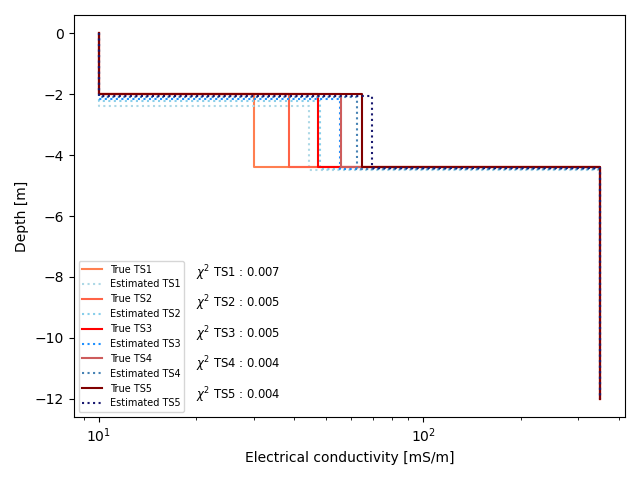

In [14]:
# Plot the models

def PlotModel(model, depths, ax=None, model_name=None, style='-', color='tomato'):
    if ax is None:
        fig, ax = plt.subplots()
    fs=7
    ax.step(model, depths, style, c=color, label=model_name)
    ax.set_xscale('log')
    ax.set_xlabel('Electrical conductivity [mS/m]')
    ax.set_ylabel('Depth [m]')
    if model_name is not None:
        ax.legend(fontsize=fs)
    plt.tight_layout()

# For plots

sigma_est_TS1 = np.array(([sigma_fs1/1000, model_3Lay_est_TS1[0], sigma_sc/1000, sigma_sc/1000]))
depths_est_TS1 = np.array([0, -model_3Lay_est_TS1[1], -model_3Lay_est_TS1[1]-model_3Lay_est_TS1[2], -dmax])

sigma_est_TS2 = np.array(([sigma_fs1/1000, model_3Lay_est_TS2[0], sigma_sc/1000, sigma_sc/1000]))
depths_est_TS2 = np.array([0, -model_3Lay_est_TS2[1], -model_3Lay_est_TS2[1]-model_3Lay_est_TS2[2], -dmax])

sigma_est_TS3 = np.array(([sigma_fs1/1000, model_3Lay_est_TS3[0], sigma_sc/1000, sigma_sc/1000]))
depths_est_TS3 = np.array([0, -model_3Lay_est_TS3[1], -model_3Lay_est_TS3[1]-model_3Lay_est_TS3[2], -dmax])

sigma_est_TS4 = np.array(([sigma_fs1/1000, model_3Lay_est_TS4[0], sigma_sc/1000, sigma_sc/1000]))
depths_est_TS4 = np.array([0, -model_3Lay_est_TS4[1], -model_3Lay_est_TS4[1]-model_3Lay_est_TS4[2], -dmax])

sigma_est_TS5 = np.array(([sigma_fs1/1000, model_3Lay_est_TS5[0], sigma_sc/1000, sigma_sc/1000]))
depths_est_TS5 = np.array([0, -model_3Lay_est_TS5[1], -model_3Lay_est_TS5[1]-model_3Lay_est_TS5[2], -dmax])

fig, ax = plt.subplots()

PlotModel(model_TS1, depths, model_name = 'True TS1', ax=ax, style='-', color='coral')
PlotModel(sigma_est_TS1*1000, depths_est_TS1, model_name='Estimated TS1', ax=ax, style=':', color='lightblue')
ax.text(20, -8, '$\chi^2$ TS1 : ' + "{:1.3f}".format(rmse(data_TS1, data_3Lay_est_TS1)), fontsize='small')

PlotModel(model_TS2, depths, model_name = 'True TS2', ax=ax, style='-', color='tomato')
PlotModel(sigma_est_TS2*1000, depths_est_TS2, model_name='Estimated TS2', ax=ax, style=':', color='skyblue')
ax.text(20, -9, '$\chi^2$ TS2 : ' + "{:1.3f}".format(rmse(data_TS2, data_3Lay_est_TS2)), fontsize='small')

PlotModel(model_TS3, depths, model_name = 'True TS3', ax=ax, style='-', color='red')
PlotModel(sigma_est_TS3*1000, depths_est_TS3, model_name='Estimated TS3', ax=ax, style=':', color='dodgerblue')
ax.text(20, -10, '$\chi^2$ TS3 : ' + "{:1.3f}".format(rmse(data_TS3, data_3Lay_est_TS3)), fontsize='small')

PlotModel(model_TS4, depths, model_name = 'True TS4', ax=ax, style='-', color='indianred')
PlotModel(sigma_est_TS4*1000, depths_est_TS4, model_name='Estimated TS4', ax=ax, style=':', color='steelblue')
ax.text(20, -11, '$\chi^2$ TS4 : ' + "{:1.3f}".format(rmse(data_TS4, data_3Lay_est_TS4)), fontsize='small')

PlotModel(model_TS5, depths, model_name = 'True TS5', ax=ax, style='-', color='maroon')
PlotModel(sigma_est_TS5*1000, depths_est_TS5, model_name='Estimated TS5', ax=ax, style=':', color='midnightblue')
ax.text(20, -12, '$\chi^2$ TS5 : ' + "{:1.3f}".format(rmse(data_TS4, data_3Lay_est_TS4)), fontsize='small')

plt.savefig('figures/Final.eps', format='eps')